In [70]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, RandomizedSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor

from scipy.stats import randint, loguniform



In [40]:
base_path = "../data/ubc-pair-grade-data"
file_paths = ["tableau-dashboard/UBCV", "tableau-dashboard-v2/UBCV"]

df = pd.DataFrame()

for file_path in file_paths:
    for year_folder in os.listdir(os.path.join(base_path, file_path)):
        for file in os.listdir(os.path.join(base_path, file_path, year_folder)):
            if file.endswith(".csv"):
                df = pd.concat([df, pd.read_csv(os.path.join(base_path, file_path, year_folder, file))])

df.to_csv("../data/ubcv_grades_tableau_all.csv", index=False)

display(df.head())


,Campus,Year,Session,Subject,Course,Detail,Section,Title,Professor,Enrolled,...,68-71,72-75,76-79,80-84,85-89,90-100,Reported,Median,Percentile (25),Percentile (75)
0,UBCV,2020,W,FIST,100,NaN,001,Introduction to Film Studies,Alexander Christensen;Alexander Clayton Christ...,109.0,...,9.0,13.0,10.0,28.0,19.0,4.0,NaN,NaN,NaN,NaN
1,UBCV,2020,W,FIST,100,NaN,003,Introduction to Film Studies,Angela Morrison;Christine Evans;Gerrit Krueper...,96.0,...,11.0,9.0,9.0,26.0,19.0,4.0,NaN,NaN,NaN,NaN
2,UBCV,2020,W,FIST,100,NaN,004,Introduction to Film Studies,Brent Strang;Harrison Wade;Jemma Dashkewytch;K...,96.0,...,10.0,8.0,15.0,18.0,24.0,7.0,NaN,NaN,NaN,NaN
3,UBCV,2020,W,FIST,100,NaN,OVERALL,Introduction to Film Studies,NaN,301.0,...,30.0,30.0,34.0,72.0,62.0,15.0,NaN,NaN,NaN,NaN
4,UBCV,2020,W,FIST,200,NaN,002,Introduction to Canadian Cinema,Christine Evans;Mila Zuo,40.0,...,2.0,3.0,5.0,12.0,14.0,0.0,NaN,NaN,NaN,NaN


In [41]:
df.shape

(108741, 29)

In [42]:
df.describe()

,Year,Course,Enrolled,Avg,Std dev,High,Low,<50,50-54,55-59,...,68-71,72-75,76-79,80-84,85-89,90-100,Reported,Median,Percentile (25),Percentile (75)
count,108741.000000,108741.000000,86089.000000,108741.000000,86089.000000,108741.000000,108741.000000,96947.000000,94292.000000,93306.000000,...,93906.000000,94655.000000,94966.000000,97550.000000,96087.00000,96656.000000,22652.000000,22652.000000,22652.000000,22652.000000
mean,2018.095015,370.216101,58.361417,80.389060,8.818913,93.072263,52.279177,1.931839,1.341620,1.843097,...,5.006709,6.686092,7.742824,11.811481,10.12598,9.650255,50.250839,82.665791,77.339091,86.965191
std,2.722866,143.871306,111.808296,7.269498,5.273125,4.572997,27.671616,7.673842,5.253221,6.623180,...,12.602954,14.887591,15.137324,19.673887,15.12103,21.162198,59.917795,6.937902,9.236363,5.502243
min,2014.000000,1.000000,5.000000,18.300000,0.000000,20.000000,0.000000,0.000000,0.000000,0.000000,...,-9.000000,-8.000000,-15.000000,-22.000000,-30.00000,-62.000000,6.000000,20.000000,0.000000,20.000000
25%,2016.000000,271.000000,15.000000,75.200000,4.685337,90.000000,33.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,3.000000,3.00000,1.000000,17.000000,78.000000,71.000000,83.000000
50%,2018.000000,388.000000,30.000000,80.209302,7.873403,94.000000,60.000000,0.000000,0.000000,0.000000,...,1.000000,3.000000,4.000000,7.000000,6.00000,5.000000,30.000000,82.500000,77.250000,87.000000
75%,2020.000000,500.000000,60.000000,85.894737,12.056059,97.000000,75.000000,1.000000,1.000000,1.000000,...,6.000000,8.000000,10.000000,14.000000,12.00000,11.000000,57.000000,88.000000,84.000000,91.000000
max,2023.000000,769.000000,3389.000000,100.000000,43.259186,100.000000,100.000000,328.000000,185.000000,239.000000,...,492.000000,650.000000,596.000000,618.000000,423.00000,1927.000000,1643.000000,100.000000,100.000000,100.000000


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 108741 entries, 0 to 3
Data columns (total 29 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Campus           108741 non-null  object 
 1   Year             108741 non-null  int64  
 2   Session          108741 non-null  object 
 3   Subject          108741 non-null  object 
 4   Course           108741 non-null  int64  
 5   Detail           19139 non-null   object 
 6   Section          108741 non-null  object 
 7   Title            108718 non-null  object 
 8   Professor        72666 non-null   object 
 9   Enrolled         86089 non-null   float64
 10  Avg              108741 non-null  float64
 11  Std dev          86089 non-null   float64
 12  High             108741 non-null  float64
 13  Low              108741 non-null  float64
 14  <50              96947 non-null   float64
 15  50-54            94292 non-null   float64
 16  55-59            93306 non-null   float64
 17  6

In [44]:
df.isna().sum()

Campus                 0
Year                   0
Session                0
Subject                0
Course                 0
Detail             89602
Section                0
Title                 23
Professor          36075
Enrolled           22652
Avg                    0
Std dev            22652
High                   0
Low                    0
<50                11794
50-54              14449
55-59              15435
60-63              15848
64-67              15675
68-71              14835
72-75              14086
76-79              13775
80-84              11191
85-89              12654
90-100             12085
Reported           86089
Median             86089
Percentile (25)    86089
Percentile (75)    86089
dtype: int64

In [45]:
df['Year'].value_counts().sort_index()

Year
2014    11829
2015    12034
2016    11917
2017    12243
2018    12604
2019    12849
2020    12613
2021     6835
2022     7838
2023     7979
Name: count, dtype: int64

Text(0.5, 1.0, 'Grade Distribution Across All Courses and Years')

<Figure size 1500x600 with 0 Axes>

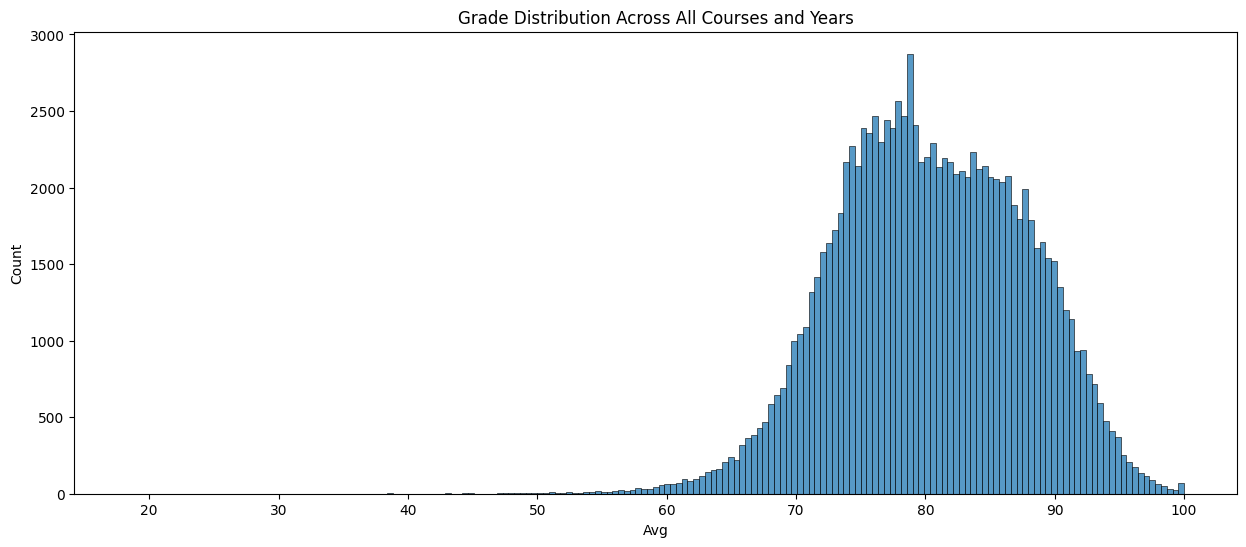

In [46]:
# Overall grade distribution patterns
plt.figure(figsize=(15, 6))

# Distribution of grades
plt.figure(figsize=(15, 6))
sns.histplot(data=df, x='Avg')
plt.title("Grade Distribution Across All Courses and Years")

In [47]:
# Drop rows with section as 'OVERALL'
df = df[df['Section'] != 'OVERALL']

# Feature engineering
df['SubjectCourse'] = df['Subject'] + df['Course'].astype(str)
df['CourseLevel'] = df['Course'].astype(str).apply(lambda x: x[0])
df['Years_Since_Start'] = df['Year'] - df['Year'].min()
df['Course_Prev_Avg'] = df.groupby('SubjectCourse')['Avg'].shift(1)
df['Course_Historical_Avg'] = df.groupby('SubjectCourse')['Avg'].transform(lambda x: x.shift(1).expanding().mean())

df = df.sort_values(['Year', 'Session'])

previous_stats = ['Avg', 'Median', 'Percentile (25)', 'Percentile (75)', 'High', 'Low',
                 '<50', '50-54', '55-59', '60-63', '64-67', '68-71',
                 '72-75', '76-79', '80-84', '85-89', '90-100']

for stat in previous_stats:
    df[f'Prev_{stat}'] = df.groupby('SubjectCourse')[stat].shift(1)

# Professor's historical statistics
for stat in previous_stats:
    df[f'Prof_Prev_{stat}'] = df.groupby('Professor')[stat].shift(1)  
    
# Professor experience (number of courses taught)
df['Prof_Courses_Taught'] = df.groupby('Professor').cumcount()

display(df)

,Campus,Year,Session,Subject,Course,Detail,Section,Title,Professor,Enrolled,...,Prof_Prev_55-59,Prof_Prev_60-63,Prof_Prev_64-67,Prof_Prev_68-71,Prof_Prev_72-75,Prof_Prev_76-79,Prof_Prev_80-84,Prof_Prev_85-89,Prof_Prev_90-100,Prof_Courses_Taught
0,UBCV,2014,S,APBI,100,NaN,98A,Soil and the Global Environment,Sandra Brown,16.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,UBCV,2014,S,APBI,200,NaN,98A,Introduction to Soil Science,Marie-Claude Fortin,23.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,UBCV,2014,S,APBI,314,NaN,941,Animals and Society,David Fraser;Elisabeth Helen Ormandy;Elisabeth...,24.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
6,UBCV,2014,S,APBI,315,NaN,941,Animal Welfare and the Ethics of Animal Use,David Fraser;Kristen Walker,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
9,UBCV,2014,S,APBI,497,B,001,Directed Studies,NaN,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,UBCV,2023,W,RMST,321,NaN,201,French Literature from the Middle Ages to the ...,Patrick Moran,NaN,...,0.0,0.0,0.0,2.0,4.0,3.0,5.0,12.0,9.0,20.0
8,UBCV,2023,W,RMST,324,NaN,101,Quebecois Literature and Culture,Isabella Huberman,NaN,...,0.0,0.0,0.0,0.0,4.0,9.0,10.0,10.0,10.0,2.0
9,UBCV,2023,W,RMST,341,NaN,101,Italian Literature and Culture of the Medieval...,Daniela Boccassini,NaN,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,6.0,3.0,21.0
10,UBCV,2023,W,RMST,345,NaN,101,Italian Fascism in Interdisciplinary Perspective,Carlo Testa,NaN,...,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,2.0,25.0


In [48]:
df = df.sort_values('Year')

split_year = df['Year'].quantile(0.8)
train_df = df[df['Year'] < split_year]
test_df = df[df['Year'] >= split_year]

In [49]:
# Column types
ordinal_cols = ['CourseLevel', 'Years_Since_Start', 'Prof_Courses_Taught']
categorical_cols = ['Campus', 'Session', 'SubjectCourse', 'Professor', "Subject"]
numeric_cols = ['Year', 'Course_Prev_Avg', 'Course_Historical_Avg']
drop_cols = ['Reported', 'Section', 'Detail', 'Median', 
                'Percentile (25)', 'Percentile (75)', 'High', 'Low',
                '<50', '50-54', '55-59', '60-63', '64-67', '68-71', 
                '72-75', '76-79', '80-84', '85-89', '90-100']

numeric_pipeline = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler()
)

categorical_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore', drop='if_binary')
)

ordinal_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
)

preprocessor = make_column_transformer(
    (numeric_pipeline, numeric_cols),
    (categorical_pipeline, categorical_cols),
    (ordinal_pipeline, ordinal_cols),
    ("drop", drop_cols),
)

In [50]:
X_train = train_df.drop(columns=['Avg'])
y_train = train_df['Avg']
X_test = test_df.drop(columns=['Avg'])
y_test = test_df['Avg']

X_train['Section'] = X_train['Section'].astype(str)

display(X_train.head())

,Campus,Year,Session,Subject,Course,Detail,Section,Title,Professor,Enrolled,...,Prof_Prev_55-59,Prof_Prev_60-63,Prof_Prev_64-67,Prof_Prev_68-71,Prof_Prev_72-75,Prof_Prev_76-79,Prof_Prev_80-84,Prof_Prev_85-89,Prof_Prev_90-100,Prof_Courses_Taught
0,UBCV,2014,S,APBI,100,NaN,98A,Soil and the Global Environment,Sandra Brown,16.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
8,UBCV,2014,W,LIBE,477,B,63C,Special Topics in Teacher Librarianship,Aaron Mueller,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
6,UBCV,2014,W,LIBE,467,NaN,63C,Information Services I,Anne Letain;Anne Marie Letain,27.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,15.0,5.0,1.0
4,UBCV,2014,W,LIBE,465,NaN,63A,Organization of Learning Resources,Allan Cho,26.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,UBCV,2014,W,LIBE,463,NaN,63A,Selection of Learning Resources I,Anne Letain;Anne Marie Letain,23.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [51]:
results = {}

dummy = DummyRegressor()

dummy.fit(X_train, y_train)
results['Dummy'] = [dummy.score(X_train, y_train), dummy.score(X_test, y_test)]

In [52]:
rg_pipe = make_pipeline(
    preprocessor,
    Ridge(random_state=42)
)

In [53]:
rg_pipe.fit(X_train, y_train)

results['Ridge'] = [rg_pipe.score(X_train, y_train), cross_val_score(rg_pipe, X_train, y_train, scoring="r2", cv=TimeSeriesSplit(n_splits=5)).mean()]
results_df = pd.DataFrame(results, index=['Train Score', 'CV Score'])

display(results_df)

/Users/adrianlam/Documents/Github/ubc-grades-analysis/analysis/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/adrianlam/Documents/Github/ubc-grades-analysis/analysis/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/adrianlam/Documents/Github/ubc-grades-analysis/analysis/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/adrianlam/Documents/Github/ubc-grades-analysis/analysis/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: User

,Dummy,Ridge
Train Score,0.000000,0.885528
CV Score,-0.043436,0.657970


In [54]:
# Get the feature importances
feature_importances = pd.Series(
    rg_pipe['ridge'].coef_,
    index=rg_pipe['columntransformer'].get_feature_names_out()
)

# Convert to DataFrame and sort
importances_df = pd.DataFrame({
    'Feature': feature_importances.index,
    'Importance': feature_importances.values
})

display(importances_df.sort_values('Importance', ascending=False).head())

,Feature,Importance
13353,pipeline-2__Professor_Binod Shrestha;Sara Shne...,15.695378
2458,pipeline-2__SubjectCourse_ELEC205,14.266664
30318,pipeline-2__Professor_Sara Shneiderman;Sonam C...,12.721215
2710,pipeline-2__SubjectCourse_EOSC111,12.663977
4930,pipeline-2__SubjectCourse_MUSC153,11.633891


/var/folders/qt/p78tc4gx2576_n2rl38t_gwr0000gn/T/ipykernel_93382/965811148.py:34: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


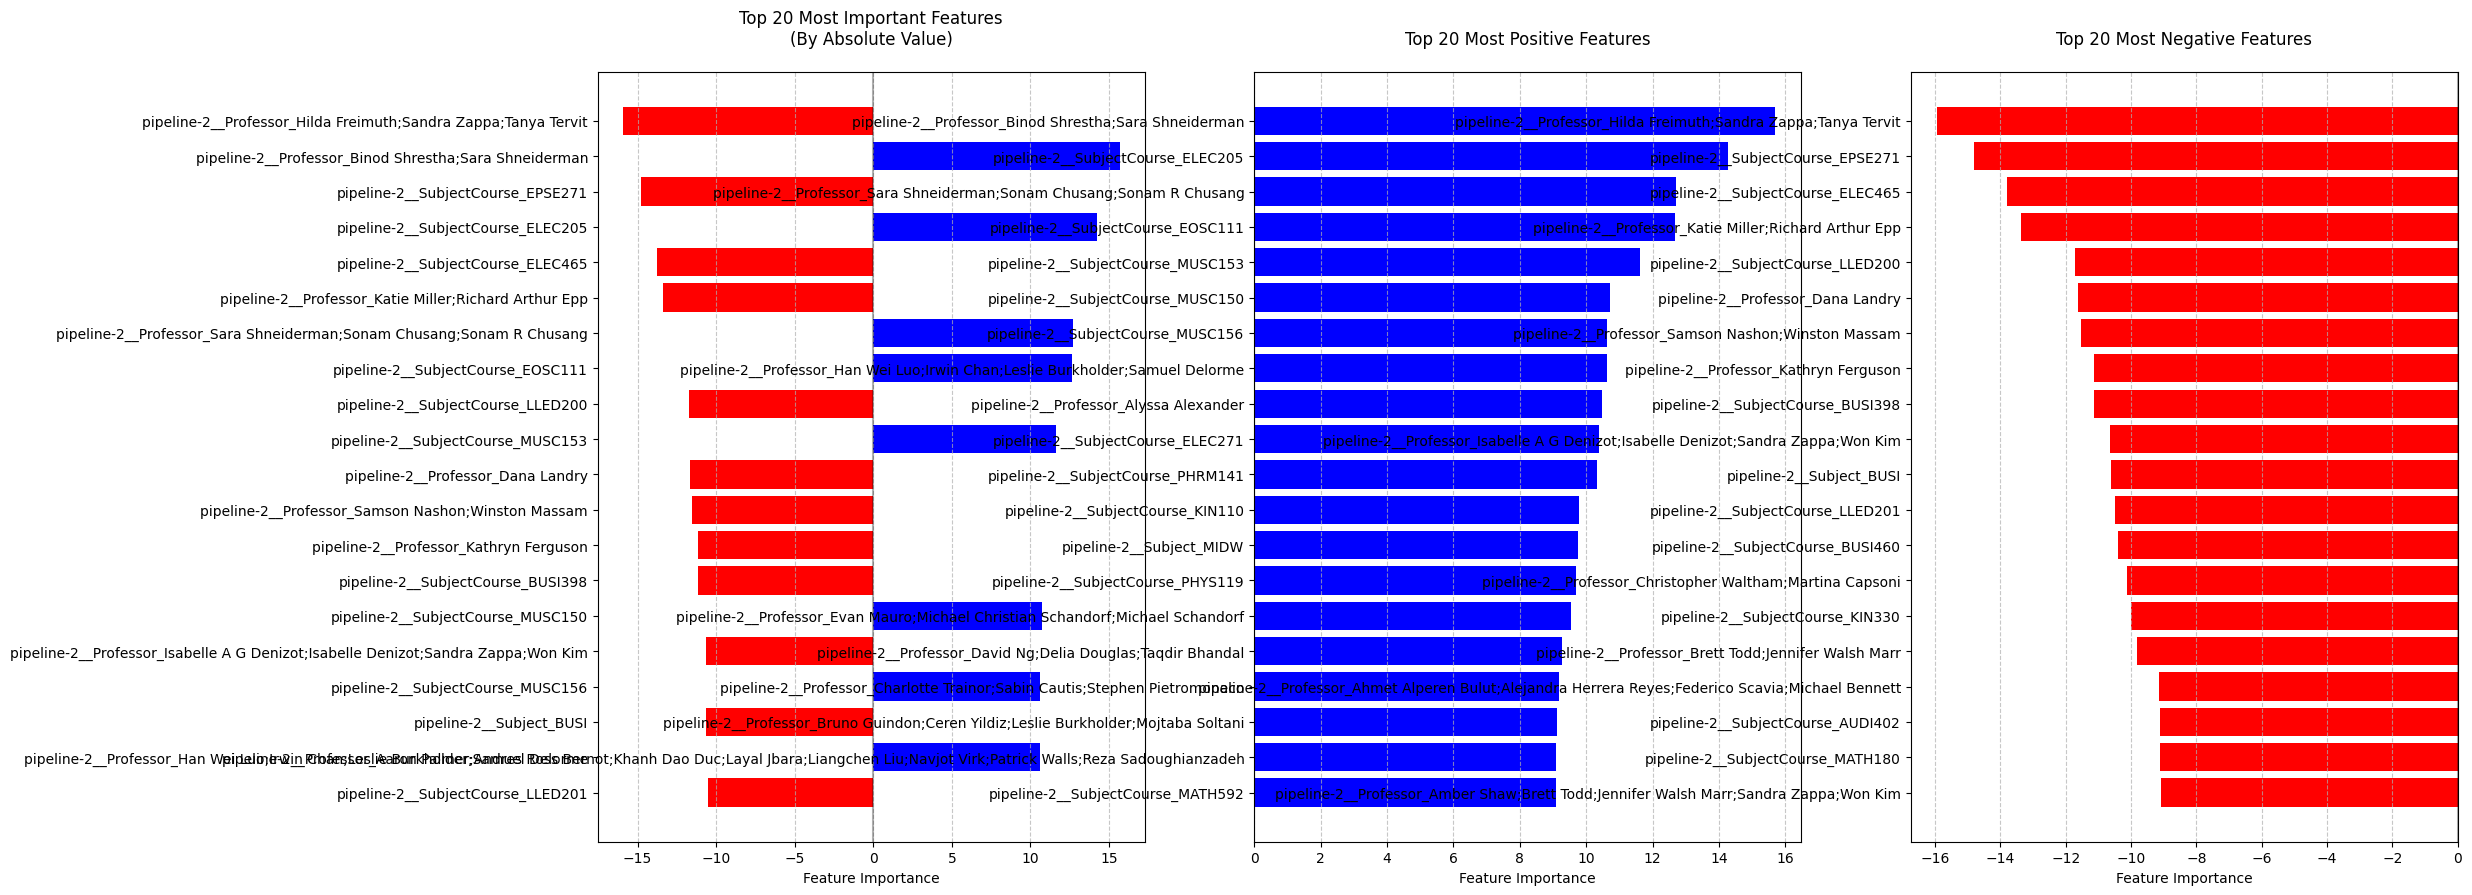

In [55]:
importances_df['Abs_Importance'] = np.abs(importances_df['Importance'])

top_overall = importances_df.sort_values('Abs_Importance', ascending=False).head(20)
top_positive = importances_df[importances_df['Importance'] > 0].sort_values('Importance', ascending=False).head(20)
top_negative = importances_df[importances_df['Importance'] < 0].sort_values('Importance').head(20)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 10))

# Plot 1: Overall most important
colors1 = ['red' if x < 0 else 'blue' for x in top_overall['Importance']]
ax1.barh(top_overall['Feature'], top_overall['Importance'], color=colors1)
ax1.set_title('Top 20 Most Important Features\n(By Absolute Value)', pad=20)
ax1.set_xlabel('Feature Importance')
ax1.invert_yaxis()
ax1.grid(axis='x', linestyle='--', alpha=0.7)
ax1.axvline(x=0, color='black', linestyle='-', alpha=0.3)

# Plot 2: Top positive features
ax2.barh(top_positive['Feature'], top_positive['Importance'], color='blue')
ax2.set_title('Top 20 Most Positive Features', pad=20)
ax2.set_xlabel('Feature Importance')
ax2.invert_yaxis()
ax2.grid(axis='x', linestyle='--', alpha=0.7)
ax2.axvline(x=0, color='black', linestyle='-', alpha=0.3)

# Plot 3: Top negative features
ax3.barh(top_negative['Feature'], top_negative['Importance'], color='red')
ax3.set_title('Top 20 Most Negative Features', pad=20)
ax3.set_xlabel('Feature Importance')
ax3.invert_yaxis()
ax3.grid(axis='x', linestyle='--', alpha=0.7)
ax3.axvline(x=0, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

,Feature,Importance,Abs_Importance,Course
2458,pipeline-2__SubjectCourse_ELEC205,14.266664,14.266664,ELEC205
2710,pipeline-2__SubjectCourse_EOSC111,12.663977,12.663977,EOSC111
4930,pipeline-2__SubjectCourse_MUSC153,11.633891,11.633891,MUSC153
4929,pipeline-2__SubjectCourse_MUSC150,10.728785,10.728785,MUSC150
4932,pipeline-2__SubjectCourse_MUSC156,10.637035,10.637035,MUSC156
2461,pipeline-2__SubjectCourse_ELEC271,10.387632,10.387632,ELEC271
5373,pipeline-2__SubjectCourse_PHRM141,10.325343,10.325343,PHRM141
3904,pipeline-2__SubjectCourse_KIN110,9.774708,9.774708,KIN110
5441,pipeline-2__SubjectCourse_PHYS119,9.705550,9.705550,PHYS119
4566,pipeline-2__SubjectCourse_MATH592,9.083165,9.083165,MATH592


,Feature,Importance,Abs_Importance,Course
2815,pipeline-2__SubjectCourse_EPSE271,14.793836,14.793836,EPSE271
2506,pipeline-2__SubjectCourse_ELEC465,13.785706,13.785706,ELEC465
4365,pipeline-2__SubjectCourse_LLED200,11.720152,11.720152,LLED200
981,pipeline-2__SubjectCourse_BUSI398,11.131045,11.131045,BUSI398
4366,pipeline-2__SubjectCourse_LLED201,10.498461,10.498461,LLED201
997,pipeline-2__SubjectCourse_BUSI460,10.412923,10.412923,BUSI460
3935,pipeline-2__SubjectCourse_KIN330,9.995327,9.995327,KIN330
579,pipeline-2__SubjectCourse_AUDI402,9.119864,9.119864,AUDI402
4453,pipeline-2__SubjectCourse_MATH180,9.105337,9.105337,MATH180


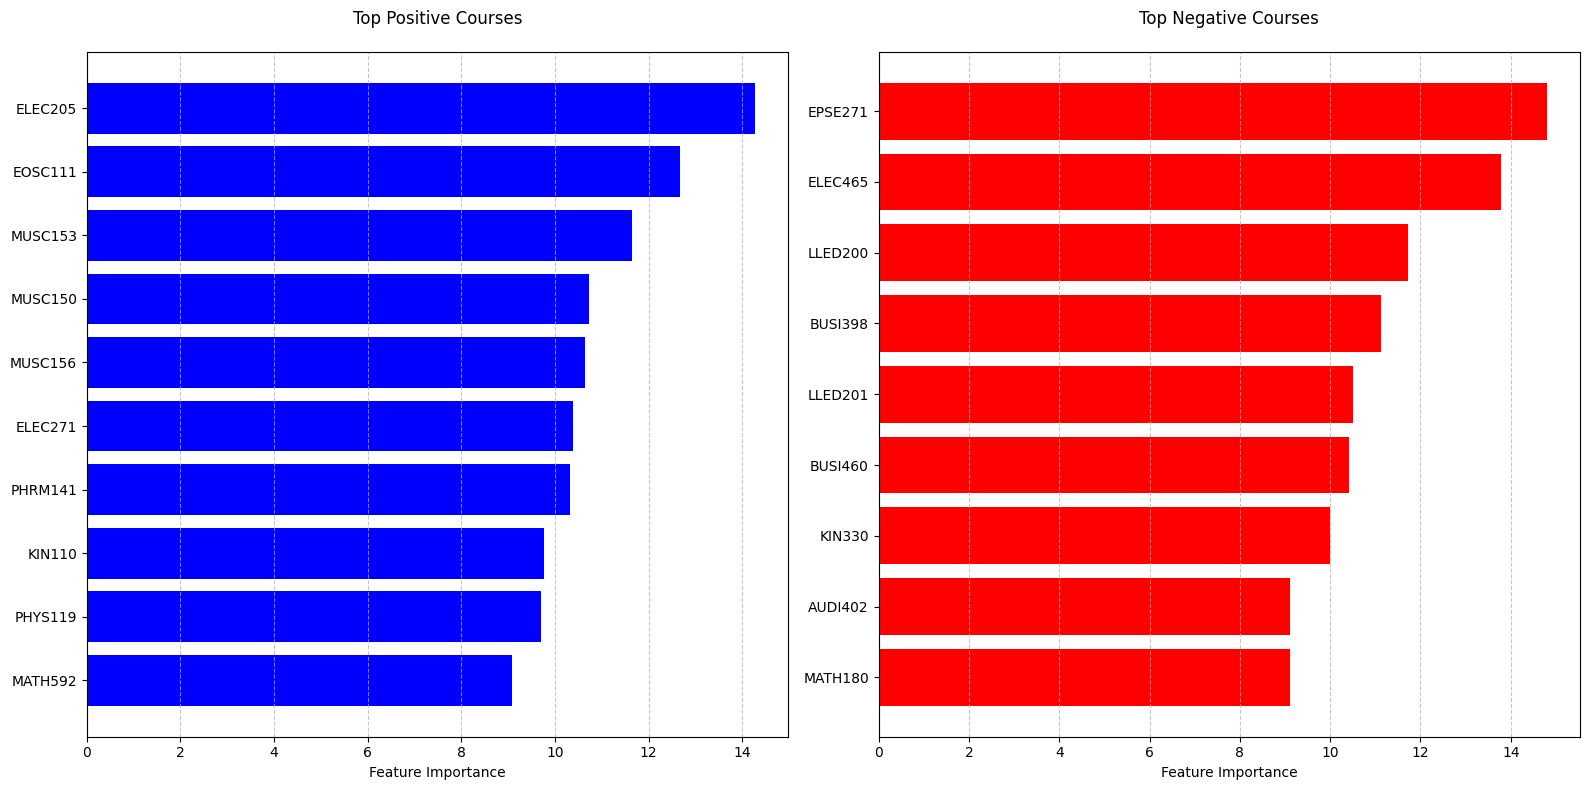

In [56]:
# Plot features/courses with the highest positive and negative coefficients
# Positive
top_positive_courses = top_positive[top_positive['Feature'].str.contains('SubjectCourse')].sort_values('Importance', ascending=False)
top_positive_courses['Course'] = top_positive_courses['Feature'].str.split('__').str[1].str.split('_').str[1]
top_positive_courses['Importance'] = top_positive_courses['Importance'].abs()
display(top_positive_courses)

# Negative
top_negative_courses = top_negative[top_negative['Feature'].str.contains('SubjectCourse')].sort_values('Importance')
top_negative_courses['Course'] = top_negative_courses['Feature'].str.split('__').str[1].str.split('_').str[1]
top_negative_courses['Importance'] = top_negative_courses['Importance'].abs()
display(top_negative_courses)

# plot both positive and negative courses
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Positive
ax1.barh(top_positive_courses['Course'], top_positive_courses['Importance'], color='blue')
ax1.set_title('Top Positive Courses', pad=20)
ax1.set_xlabel('Feature Importance')
ax1.invert_yaxis()
ax1.grid(axis='x', linestyle='--', alpha=0.7)
ax1.axvline(x=0, color='black', linestyle='-', alpha=0.3)

# Negative
ax2.barh(top_negative_courses['Course'], top_negative_courses['Importance'], color='red')
ax2.set_title('Top Negative Courses', pad=20)
ax2.set_xlabel('Feature Importance')
ax2.invert_yaxis()
ax2.grid(axis='x', linestyle='--', alpha=0.7)
ax2.axvline(x=0, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

/var/folders/qt/p78tc4gx2576_n2rl38t_gwr0000gn/T/ipykernel_93382/3177661377.py:28: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


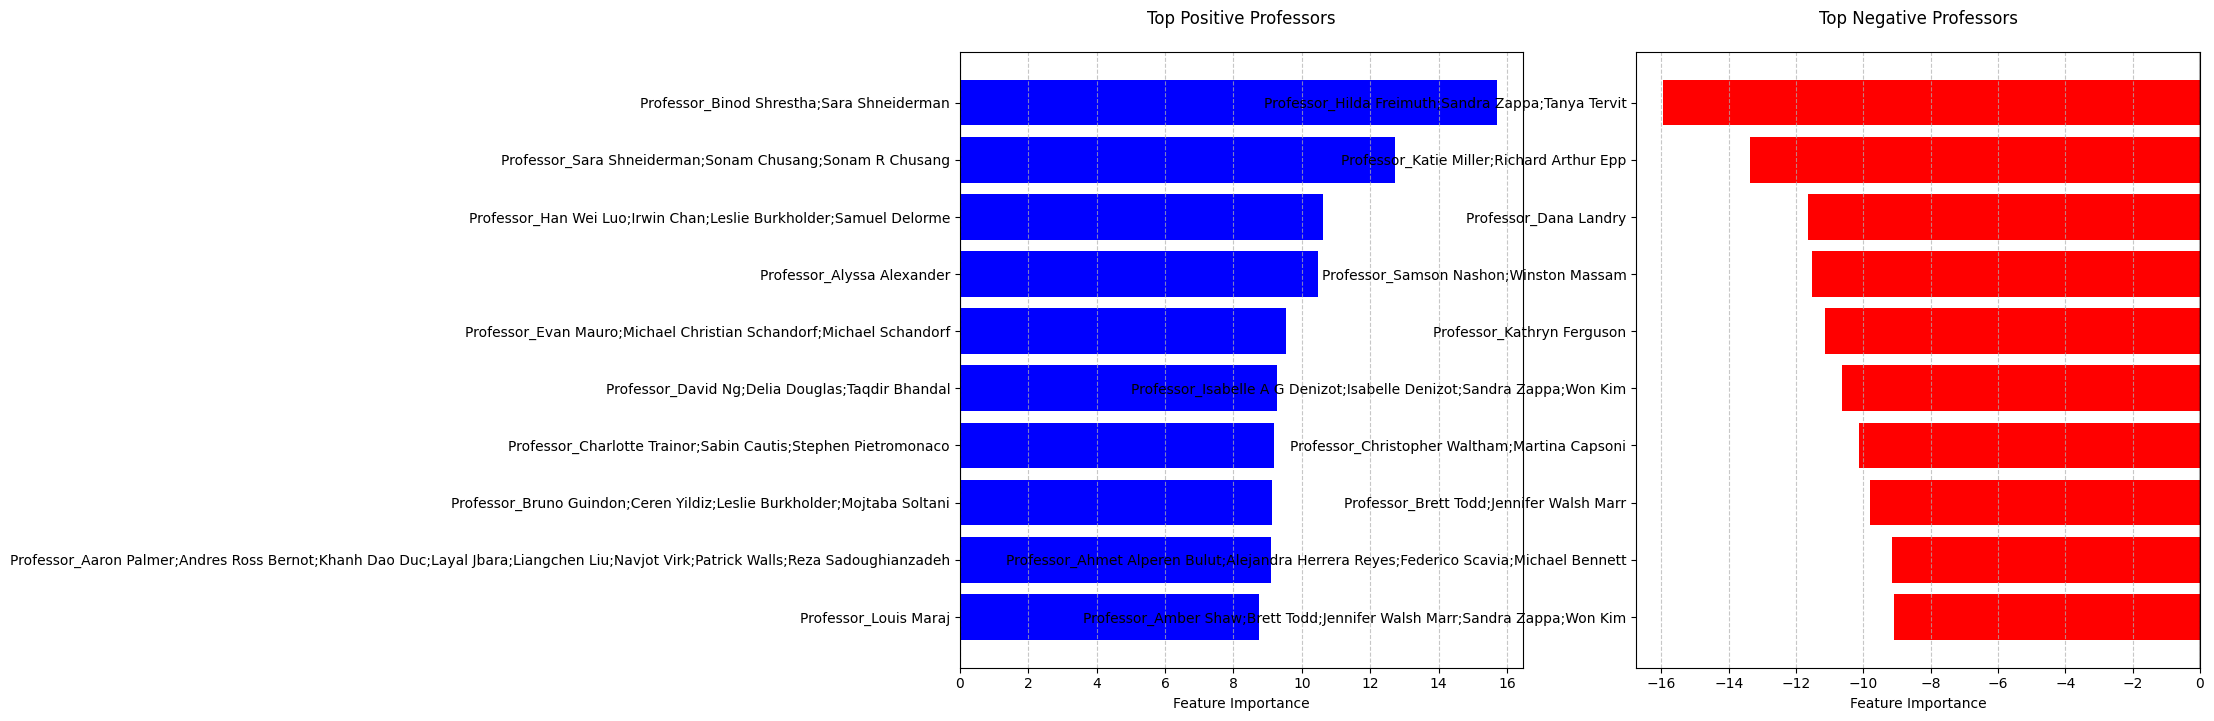

In [57]:
professor_importances = importances_df[importances_df['Feature'].str.contains('Professor')].copy()
professor_importances['Abs_Importance'] = np.abs(professor_importances['Importance'])

top_positive_profs = professor_importances[professor_importances['Importance'] > 0].sort_values('Importance', ascending=False).head(10)
top_negative_profs = professor_importances[professor_importances['Importance'] < 0].sort_values('Importance').head(10)

top_positive_profs['Professor'] = top_positive_profs['Feature'].str.split('__').str[1]
top_negative_profs['Professor'] = top_negative_profs['Feature'].str.split('__').str[1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Positive
ax1.barh(top_positive_profs['Professor'], top_positive_profs['Importance'], color='blue')
ax1.set_title('Top Positive Professors', pad=20)
ax1.set_xlabel('Feature Importance')
ax1.invert_yaxis()
ax1.grid(axis='x', linestyle='--', alpha=0.7)
ax1.axvline(x=0, color='black', linestyle='-', alpha=0.3)

# Negative
ax2.barh(top_negative_profs['Professor'], top_negative_profs['Importance'], color='red')
ax2.set_title('Top Negative Professors', pad=20)
ax2.set_xlabel('Feature Importance')
ax2.invert_yaxis()
ax2.grid(axis='x', linestyle='--', alpha=0.7)
ax2.axvline(x=0, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

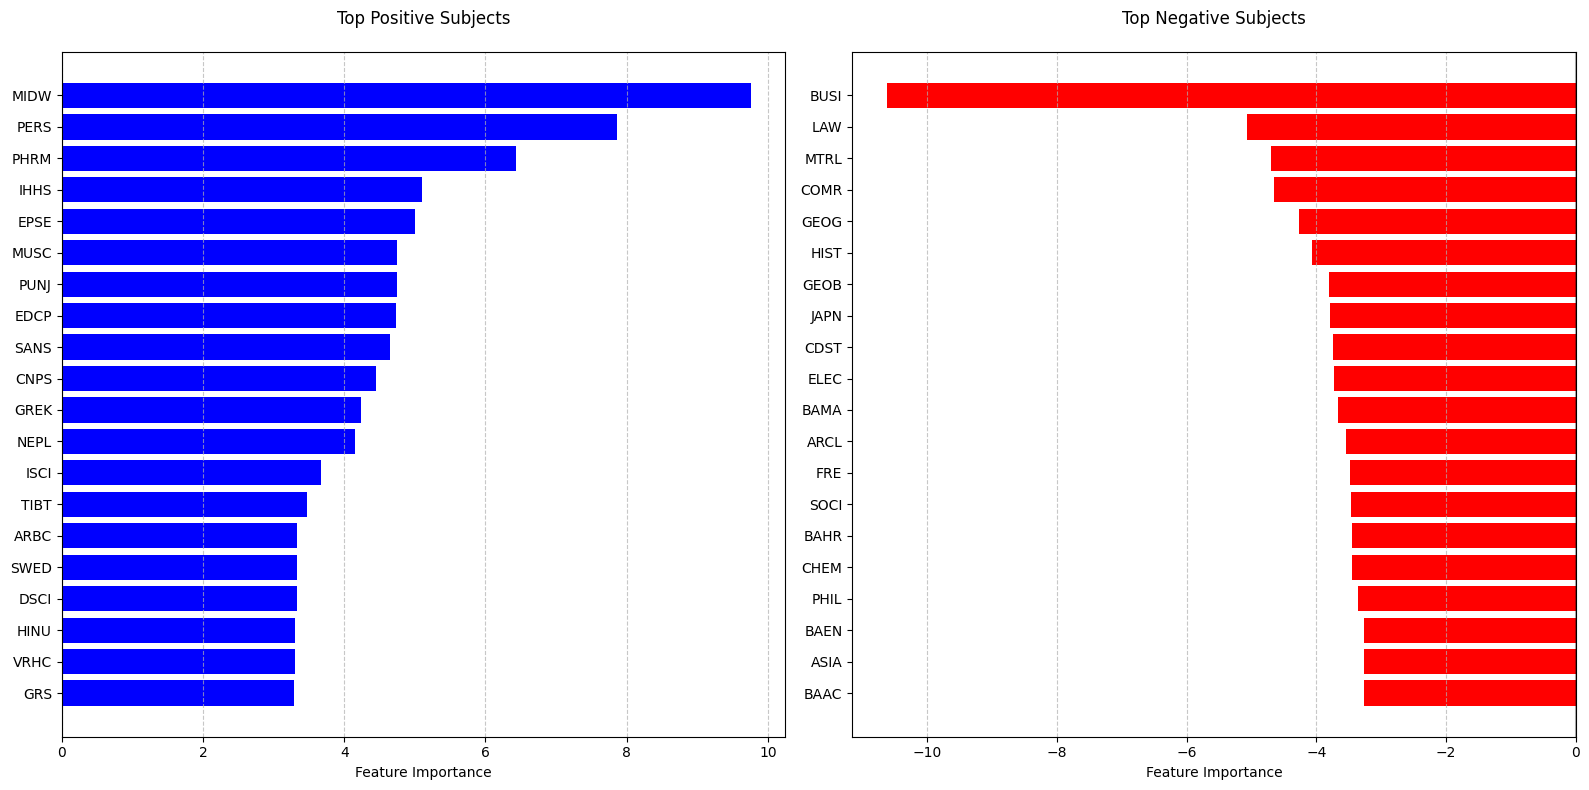

In [58]:
subject_importances = importances_df[importances_df['Feature'].str.contains('Subject_')].copy()
subject_importances['Abs_Importance'] = np.abs(subject_importances['Importance'])

top_positive_subjects = subject_importances[subject_importances['Importance'] > 0].sort_values('Importance', ascending=False).head(20)
top_negative_subjects = subject_importances[subject_importances['Importance'] < 0].sort_values('Importance').head(20)

top_positive_subjects['Subject'] = top_positive_subjects['Feature'].str.split('__').str[1].str.split('_').str[1]
top_negative_subjects['Subject'] = top_negative_subjects['Feature'].str.split('__').str[1].str.split('_').str[1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Positive
ax1.barh(top_positive_subjects['Subject'], top_positive_subjects['Importance'], color='blue')
ax1.set_title('Top Positive Subjects', pad=20)
ax1.set_xlabel('Feature Importance')
ax1.invert_yaxis()
ax1.grid(axis='x', linestyle='--', alpha=0.7)
ax1.axvline(x=0, color='black', linestyle='-', alpha=0.3)

# Negative
ax2.barh(top_negative_subjects['Subject'], top_negative_subjects['Importance'], color='red')
ax2.set_title('Top Negative Subjects', pad=20)
ax2.set_xlabel('Feature Importance')
ax2.invert_yaxis()
ax2.grid(axis='x', linestyle='--', alpha=0.7)
ax2.axvline(x=0, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

In [59]:
# Sample predictions in this form
example = pd.DataFrame({
    'Year': 2024,
    'Session': 'W',
    'Campus': 'UBCV',
    'Subject': 'MATH',
    'Course': 100,
    'Section': '101',
    'Professor': ['John Doe'],
    'SubjectCourse': 'MATH100',
    'CourseLevel': 1,
    'Years_Since_Start': 1,
    'Course_Prev_Avg': 75,
    'Course_Historical_Avg': 70,
    'Prof_Courses_Taught': 10
})

rg_pipe.predict(example)

/Users/adrianlam/Documents/Github/ubc-grades-analysis/analysis/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


array([66.33892625])

In [66]:
rf_pipe = make_pipeline(
    preprocessor,
    RandomForestRegressor(random_state=42)
)

gb_pipe = make_pipeline(
    preprocessor,
    GradientBoostingRegressor(random_state=42)
)

rf_param_dist = {
    'randomforestregressor__n_estimators': randint(100, 300),
    'randomforestregressor__max_depth': randint(3, 8),
}

# GradientBoosting hyperparameter space
gb_param_dist = {
    'gradientboostingregressor__n_estimators': randint(100, 500),
    'gradientboostingregressor__learning_rate': loguniform(1e-3, 1),
    'gradientboostingregressor__max_depth': randint(3, 10),
    'gradientboostingregressor__alpha': loguniform(1e-3, 10)
}

# Ridge hyperparameter space
ridge_param_dist = {
    'ridge__alpha': loguniform(1e-3, 100)
}

models = {
    'rf': (rf_pipe, rf_param_dist),
    'gb': (gb_pipe, gb_param_dist),
    'ridge': (rg_pipe, ridge_param_dist)
}
best_models = {}
for name, (model, param_dist) in models.items():
    print(f"Tuning {name}...")
    
    search = RandomizedSearchCV(
        model,
        param_distributions=param_dist,
        n_iter=10,
        cv=TimeSeriesSplit(n_splits=3),
        scoring='r2',
        n_jobs=-1,
        random_state=42,
        verbose=1
    )
    
    search.fit(X_train, y_train)
    best_models[name] = search.best_estimator_
    print(f"Best score for {name}: {search.best_score_:.4f}")
    print(f"Best parameters for {name}: {search.best_params_}\n")

# Create weighted ensemble based on CV scores
weights = [search.best_score_ for name in ['rf', 'gb', 'ridge']]
tuned_ensemble = VotingRegressor(
    [(name, model) for name, model in best_models.items()],
    weights=weights
)

tuned_ensemble.fit(X_train, y_train)

# Use cross validation to evaluate
cv = TimeSeriesSplit(n_splits=5)
ensemble_scores = cross_val_score(tuned_ensemble, X_train, y_train, cv=cv, scoring='r2')


results['Tuned Ensemble'] = [tuned_ensemble.score(X_train, y_train), ensemble_scores.mean()]
results_df = pd.DataFrame(results, index=['Train Score', 'CV Score'])

display(results_df)


Tuning rf...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/adrianlam/Documents/Github/ubc-grades-analysis/analysis/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/adrianlam/Documents/Github/ubc-grades-analysis/analysis/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/adrianlam/Documents/Github/ubc-grades-analysis/analysis/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/adrianlam/Documents/Github/ubc-grades-analysis/analysis/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: User

Best score for rf: 0.6461
Best parameters for rf: {'randomforestregressor__max_depth': 7, 'randomforestregressor__n_estimators': 199}

Tuning gb...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/adrianlam/Documents/Github/ubc-grades-analysis/analysis/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/adrianlam/Documents/Github/ubc-grades-analysis/analysis/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/adrianlam/Documents/Github/ubc-grades-analysis/analysis/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/adrianlam/Documents/Github/ubc-grades-analysis/analysis/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: User

Best score for gb: 0.6616
Best parameters for gb: {'gradientboostingregressor__alpha': np.float64(0.0012366582530130832), 'gradientboostingregressor__learning_rate': np.float64(0.03752528339573976), 'gradientboostingregressor__max_depth': 9, 'gradientboostingregressor__n_estimators': 269}

Tuning ridge...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/adrianlam/Documents/Github/ubc-grades-analysis/analysis/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/adrianlam/Documents/Github/ubc-grades-analysis/analysis/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/adrianlam/Documents/Github/ubc-grades-analysis/analysis/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/adrianlam/Documents/Github/ubc-grades-analysis/analysis/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: User

Best score for ridge: 0.6319
Best parameters for ridge: {'ridge__alpha': np.float64(1.0129197956845732)}



/Users/adrianlam/Documents/Github/ubc-grades-analysis/analysis/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/adrianlam/Documents/Github/ubc-grades-analysis/analysis/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/adrianlam/Documents/Github/ubc-grades-analysis/analysis/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/adrianlam/Documents/Github/ubc-grades-analysis/analysis/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: User

,Dummy,Ridge,Tuned Ensemble,Stacking
Train Score,0.000000,0.885528,0.812804,0.829192
CV Score,-0.043436,0.657970,0.690451,0.692529


In [69]:
# Ridge with tuned hyperparameters
rg_pipe = make_pipeline(
    preprocessor,
    Ridge(alpha=0.6319, random_state=42)
)

rg_pipe.fit(X_train, y_train)

results['Ridge Tuned'] = [rg_pipe.score(X_train, y_train), cross_val_score(rg_pipe, X_train, y_train, scoring="r2", cv=TimeSeriesSplit(n_splits=5)).mean()]
results_df = pd.DataFrame(results, index=['Train Score', 'CV Score'])

results_df.drop(columns=['Ridge'], inplace=True)

display(results_df)

/Users/adrianlam/Documents/Github/ubc-grades-analysis/analysis/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/adrianlam/Documents/Github/ubc-grades-analysis/analysis/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/adrianlam/Documents/Github/ubc-grades-analysis/analysis/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/adrianlam/Documents/Github/ubc-grades-analysis/analysis/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: User

,Dummy,Tuned Ensemble,Stacking,Random Forest,Gradient Boosting,Ridge Tuned
Train Score,0.000000,0.812804,0.829192,0.699772,0.778527,0.897542
CV Score,-0.043436,0.690451,0.692529,0.656362,0.675184,0.655986


In [67]:
# Random Forest with tuned hyperparameters
rf_pipe = make_pipeline(
    preprocessor,
    RandomForestRegressor(random_state=42, max_depth=7, n_estimators=199)
)

rf_pipe.fit(X_train, y_train)

results['Random Forest'] = [rf_pipe.score(X_train, y_train), cross_val_score(rf_pipe, X_train, y_train, scoring="r2", cv=TimeSeriesSplit(n_splits=5)).mean()]

/Users/adrianlam/Documents/Github/ubc-grades-analysis/analysis/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/adrianlam/Documents/Github/ubc-grades-analysis/analysis/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/adrianlam/Documents/Github/ubc-grades-analysis/analysis/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/adrianlam/Documents/Github/ubc-grades-analysis/analysis/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: User

,Dummy,Ridge,Tuned Ensemble,Stacking,Random Forest,Gradient Boosting
Train Score,0.000000,0.885528,0.812804,0.829192,0.699772,0.778527
CV Score,-0.043436,0.657970,0.690451,0.692529,0.656362,0.675184


In [ ]:
# Gradient Boosting with tuned hyperparameters
gb_pipe = make_pipeline(
    preprocessor,
    GradientBoostingRegressor(random_state=42, max_depth=9, n_estimators=269, learning_rate=0.03752528339573976, alpha=0.0012366582530130832)
)

gb_pipe.fit(X_train, y_train)

results['Gradient Boosting'] = [gb_pipe.score(X_train, y_train), cross_val_score(gb_pipe, X_train, y_train, scoring="r2", cv=TimeSeriesSplit(n_splits=5)).mean()]

In [ ]:
results_df = pd.DataFrame(results, index=['Train Score', 'CV Score'])
display(results_df)